Context: https://www.kaggle.com/hellbuoy/car-price-prediction

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [8]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.sample(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
169,170,2,toyota starlet,gas,std,two,hatchback,rwd,front,98.4,176.2,65.6,52.0,2551,ohc,four,146,mpfi,3.62,3.50,9.3,116,4800,24,30,9989.0
186,187,2,volkswagen 411 (sw),gas,std,four,sedan,fwd,front,97.3,171.7,65.5,55.7,2275,ohc,four,109,mpfi,3.19,3.40,9.0,85,5250,27,34,8495.0
116,117,0,peugeot 504,diesel,turbo,four,sedan,rwd,front,107.9,186.7,68.4,56.7,3252,l,four,152,idi,3.70,3.52,21.0,95,4150,28,33,17950.0
72,73,3,buick skylark,gas,std,two,convertible,rwd,front,96.6,180.3,70.5,50.8,3685,ohcv,eight,234,mpfi,3.46,3.10,8.3,155,4750,16,18,35056.0
180,181,-1,toyota starlet,gas,std,four,sedan,rwd,front,104.5,187.8,66.5,54.1,3131,dohc,six,171,mpfi,3.27,3.35,9.2,156,5200,20,24,15690.0


# Data Exploration

## How many rows/cols?

In [9]:
cars.shape

(205, 26)

- Are there any duplicates?

In [12]:
cars.duplicated().sum()

0

## Check each col's dtype

In [3]:
cars.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

## Examine numeric data

In [13]:
def missing_ratio(s):
    return s.isna().sum() * 100 / len(s)

num_cols = cars.select_dtypes([np.int64, np.float64]).columns
cars[num_cols].agg([missing_ratio, pd.Series.min, pd.Series.max, pd.Series.nunique])

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,-2.0,86.6,141.1,60.3,47.8,1488.0,61.0,2.54,2.07,7.0,48.0,4150.0,13.0,16.0,5118.0
max,205.0,3.0,120.9,208.1,72.3,59.8,4066.0,326.0,3.94,4.17,23.0,288.0,6600.0,49.0,54.0,45400.0
nunique,205.0,6.0,53.0,75.0,44.0,49.0,171.0,44.0,38.00,37.00,32.0,59.0,23.0,29.0,30.0,189.0


- No missing data; min & max vals are quite reasonable. However, based on the columns' description in **Data Dictionary - carprices.xlsx**, `car_ID` & `symboling` should not be numeric column so they should be dropped from `num_cols`

In [17]:
num_cols = num_cols[2:]
num_cols

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')

- Since linear regression assumes the linear relationship b/w independent (`price`) & dependent cols. So let's check the Pearson correlation b/w `price` & other cols. Because visualizing using pair-plot for 26 features are quite hard to read, a heatmap will be used instead 
- Also, linear regression is sensitive to multicollinearity. In other words, there should be no or little multicollinearity. So let's check for that, too

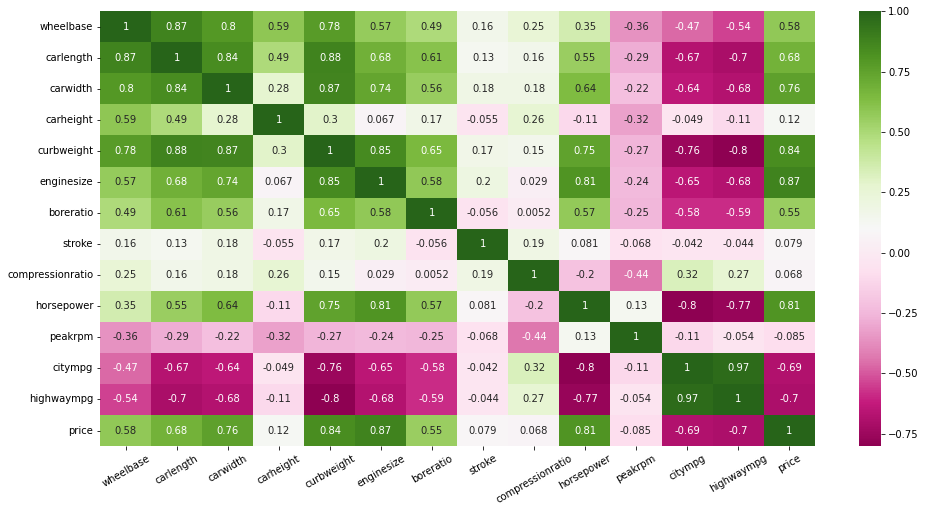

In [24]:
plt.figure(figsize=(16,8))

# cmap ref: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
ax = sns.heatmap(cars[num_cols].corr(), cmap="PiYG", annot=True) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

Insights:
- `price` is highly correlated (positive & negative) with all the <font color='green'>green</font> & <font color='pink'>pink</font> cells in the last row since the corr > 0.5 (0.5 is my 'high correlation threshold')
- Multicollinearity: many independent variables are highly correlated (all 4 corners, those in green & bold pink)

## Examine categorical data

In [27]:
cat_cols = cars.select_dtypes([object]).columns
cars[cat_cols].agg([missing_ratio, pd.Series.nunique])

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,147.0,2.0,2.0,2.0,5.0,3.0,2.0,7.0,7.0,8.0


In [28]:
len(cat_cols)

10